In [4]:
import pandas as pd
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'

#Data loading
df = pd.read_csv("resultFiles/featureExtractionV5_by_Jun/CD4.Ranksum.RFECV.act.csv", engine='c', index_col=0)
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')


In [5]:
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit
import itertools
def _LoadDiseaseDuration(df, meta_data, returntype='long'):
    """
    df : Expression or activation score matrix
    meta_data : meta data which contains duration and sample ID
    output: long DD samples and short DD samples by list, or healthy samples and short DD samples by list
    """
    # checking multiple element for returntype
    if returntype.count(',')>1: raise ValueError('No more than 2 elements for returntype')

    if returntype.find(',')==-1: # if returnType is single(long and healthy)
        # Sample by disease category
        sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
        
        # Sort by disease category and exclude uknown samples
        patient_samples = [] # patient samples
        healthy_samples = [] # healthy samples
        for samples, category in zip(sample_list, sample_category):
            if category=='Healthy':
                healthy_samples = samples
            else:
                if category!='Unknown':# Excluding unknown samples
                    patient_samples.append(samples)

        patient_samples = list(itertools.chain(*patient_samples)) # flatten
        patient_samples = list(set(patient_samples).intersection(df.columns.tolist())) # intersected with act score matrix
        healthy_samples = list(set(healthy_samples).intersection(df.columns.tolist())) # intersected with act score matrix
        patient_meta = meta_data.loc[meta_data['HCVB_ID'].isin(patient_samples)] # Make patient metadata

        longDD_samples, shortDD_samples = exttoolkit.get_sample_name_by_contValues(patient_meta, 'HCVB_ID', 'DiseaseDuration', 25)
        longDD_samples = list(set(longDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
        shortDD_samples = list(set(shortDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix

    else: # if returnType is multiple(List)
        # Sample by disease category
        sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
        category1 = returntype.split(',')[0]
        category2 = returntype.split(',')[1]
        
        # Sort by disease category and exclude uknown samples
        patient_samples = [] # patient samples
        healthy_samples = [] # healthy samples
        for samples, category in zip(sample_list, sample_category):
            if category==category1:
                category1_samples = list(set(samples).intersection(df.columns.tolist())) # intersected with act score matrix
            elif category==category2:
                category2_samples = list(set(samples).intersection(df.columns.tolist())) # intersected with act score matrix

    # return result
    if returntype=='long':
        return longDD_samples, shortDD_samples
    elif returntype=='healthy':
        return healthy_samples, shortDD_samples
    else:
        return category1_samples, category2_samples


In [6]:
df_cd4 = df.copy()
longDD_samples, shortDD_samples = _LoadDiseaseDuration(df_cd4, meta_data, 'RR,CIS')
df_cd4 = df_cd4[longDD_samples+shortDD_samples]
df_cd4 = df_cd4.subtract(df_cd4.median(axis=1), axis=0)


X = df_cd4.T.values # Training sample
y = [0]*len(longDD_samples)+[1]*len(shortDD_samples) # Training y
X.shape

(119, 556)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

auc_arr = []
val_auc = []

for t in list(range(0,100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=t)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=t)

    #randomState = list(range(0,5))

    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc_arr.append([t, metrics.auc(fpr, tpr)])
    
    y_val_pred = clf.predict(X_val)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred, pos_label=1)
    val_auc.append([t, metrics.auc(fpr, tpr)])

auc_test_df = pd.DataFrame(data=auc_arr, columns=['state', 'auc']).set_index('state')
auc_val_df = pd.DataFrame(data=val_auc, columns=['state', 'auc']).set_index('state')

In [8]:
auc_df = pd.concat([auc_test_df, auc_val_df], axis=1)
auc_df.columns = ['test_auc', 'val_auc']
auc_df['diff'] = auc_df['test_auc'] - auc_df['val_auc']
auc_df

,test_auc,val_auc,diff
state,,,
0,0.875000,0.822222,0.052778
1,1.000000,0.944444,0.055556
2,0.857143,0.970588,-0.113445
3,0.828571,0.873684,-0.045113
4,0.900000,0.900000,0.000000
...,...,...,...
95,0.687500,0.954545,-0.267045
96,0.869748,0.941176,-0.071429
97,0.911111,0.937500,-0.026389


/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

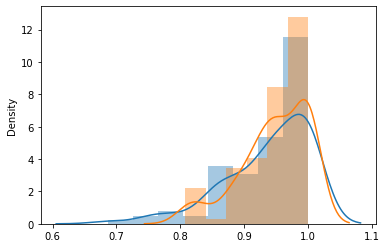

In [9]:
import seaborn as sns
sns.distplot(auc_test_df['auc'].values.tolist())
sns.distplot(auc_val_df['auc'].values.tolist())

/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

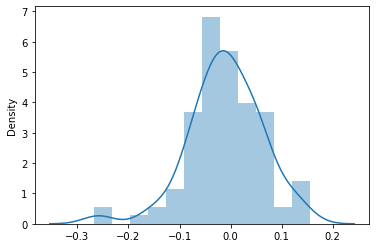

In [11]:
sns.distplot(auc_df['diff'].values.tolist())